# 🧠 Final Project — Reported Crime (STARS Category Offenses) after 2024-06-03  
**Course:** IT2053C • **Author:** Silas Curry  

> Dataset: *Reported Crime (STARS Category Offenses) on or after 6/3/2024* — City of Cincinnati Open Data  

### Executive Summary  
- **Context / Stakeholder:**  
  The **Cincinnati Police Department (CPD)** and city partners rely on accurate and up-to-date reporting to understand local crime dynamics and allocate resources effectively. After the transition to a new Records Management System (RMS) on **June 3, 2024**, reported crimes were categorized using the **STARS (Standardized Tracking and Reporting System) Offense Classification**, which groups incidents by offense type (e.g., theft, burglary, assault) for consistent reporting across departments.  
  This analysis supports **public safety leadership, neighborhood councils, and operational planners** by identifying when, where, and what types of incidents occur most frequently within the city.  

- **Goal:**  
  Examine **spatial and temporal patterns** in reported crime incidents citywide after the RMS transition. The project focuses on identifying **peak time windows**, **high-volume offense categories**, and **neighborhood hotspots** that can inform patrol scheduling, prevention initiatives, and community engagement strategies.  

- **Key Findings:**  
  - **Temporal Trends:** Crime activity concentrates between **late morning and early evening (11 AM–6 PM)**, with the **highest incident levels on Mondays**. These consistent weekday peaks highlight key opportunities for targeted resource deployment.  
  - **STARS Category Concentration:** A small number of categories—particularly **Part 2 offenses**, **personal/other theft**, **auto-related theft**, and **burglary/break-ins**—account for the majority of all reported incidents. *Part 2 offenses* encompass non-index crimes such as vandalism, disorderly conduct, fraud, and minor assaults, which together represent a large share of community-level safety concerns.  
  - **Geographic Distribution:** Incident counts vary widely by neighborhood. **Westwood, CBD/Riverfront, Over-the-Rhine, and West Price Hill** report the highest activity levels, demonstrating the need for neighborhood-specific strategies rather than uniform citywide approaches.  
  - **Operational Insights:** Most cases are closed quickly or cleared by adult arrest, suggesting efficient administrative handling. However, a notable number of cases end as **“Victim Refuses to Cooperate,”** signaling areas for improved trust-building and victim support.  

- **Recommendations:**  
  - Implement **time-targeted patrols and prevention campaigns** focused on property crimes during high-activity hours and early weekdays.  
  - Develop a **neighborhood-level safety dashboard** to track weekly changes and visualize hotspots for CPD and community leaders.  
  - Integrate this dataset with complementary sources (e.g., calls for service, arrests, and outcome data) to enhance situational awareness and policy evaluation.  
  - Maintain strong **data governance and lineage** awareness due to the RMS transition—avoid combining pre- and post-June 2024 data without schema harmonization to ensure valid comparisons.


## 📊 Dataset Selection  

**Source:**  
[City of Cincinnati Open Data Portal – Reported Crime (STARS Category Offenses) on or after 6/3/2024](https://data.cincinnati-oh.gov/safety/Reported-Crime-STARS-Category-Offenses-on-or-after/7aqy-xrv9/about_data)  
This dataset is maintained by the **City of Cincinnati’s Office of Performance & Data Analytics (OPDA)** and represents reported crime incidents classified under the **STARS (Standardized Tracking and Reporting System)** offense categories.  

**Additional Resources:**  
- Official **CincyInsights dashboard** for interactive visualization  
- Portal story and banner statements for data context  
- Historical (pre–June 3, 2024) records available in a **separate dataset** due to the CPD RMS system transition  

**License / Terms:**  
Open public data — anonymized and geospatially skewed to protect privacy.  
- Street addresses redacted to block level (last two digits replaced with “XX”)  
- Latitude/longitude coordinates randomized within the same block  

**Dataset Size:**  
≈ **37,900 rows** × **17 columns** (as of **November 12, 2025**)  
Updated **daily** on the City of Cincinnati Open Data portal.  

**Why This Dataset:**  
This dataset was selected for its **timeliness, public relevance, and operational value**. It provides a reliable, daily-updated view of reported crime activity across Cincinnati, making it ideal for exploring trends that inform **staffing, patrol allocation, and community outreach** strategies.


### Columns (17)
| Column | Description | Type |
|---|---|---|
| INCIDENT_NO | Unique incident id | text |
| DateReported | Report timestamp | datetime (string in source) |
| DateFrom | Incident start | datetime (string in source) |
| DateTo | Incident end | datetime (string in source) |
| BEAT | Patrol beat | text |
| CLSD | Clearance status | text |
| STARS_Category | Offense category | text |
| DAY_OF_WEEK | Day name | text |
| CPD_Neighborhood | CPD neighborhood | text |
| Hour_From | Start hour | number |
| Hour_To | End hour | number |
| type | Part category | text |
| SNA_Neighborhood | SNA neighborhood | text |
| CC_Neighborhood | CC neighborhood | text |
| ADDRESS_X | Redacted address | text |
| LATITUDE_X | Latitude (skewed) | number |
| LONGITUDE_X | Longitude (skewed) | number |

### Stakeholder‑framed Questions
1. **When** do the highest incident levels occur (by day and hour) and do patterns differ by **STARS category**?  
2. **Where** are incidents concentrated by **neighborhood** and category?  
3. Which **categories** dominate volume post‑transition, and how stable are they **week‑over‑week**?  
4. Are there **seasonal or monthly** trends since 2024‑06‑03 (bounded by the dataset’s timeframe)?

### Visualization Plan (8+ figs + 2 interactives)
- Distribution of incidents by **weekday** (bar).  
- Distribution of incidents by **hour** (bar).  
- **Day × Hour** heatmap of counts.  
- Top **STARS categories** (bar).  
- Incidents by **neighborhood** (top‑N bar).  
- **Weekly** or **monthly** time series since 2024‑06‑03 (line).  
- **Correlation** matrix for numeric features (sanity).  
- Clearance status **CLSD** distribution (bar).  
- **Interactive 1 (Plotly):** Map incidents (scatter_geo) color by category, hover details.  
- **Interactive 2 (Plotly):** Filterable category trend (dropdown/radio) over time.

In [ ]:
# 🚀 Imports & Settings (simple with checks)
import os
import io
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try Seaborn
try:
  import seaborn as sns
  SEABORN_OK = True
except Exception as e:
  SEABORN_OK = False
  print("⚠️ Seaborn not available:", e)

# Try Plotly
try:
  import plotly.express as px
  import plotly.graph_objects as go
  PLOTLY_OK = True
except Exception as e:
  PLOTLY_OK = False
  print("⚠️ Plotly not available:", e)

# Quick diagnostic printout
print("\n✅ Import Summary")
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {'✅ OK' if SEABORN_OK else '❌ Missing'}")
print(f"Plotly: {'✅ OK' if PLOTLY_OK else '❌ Missing'}")

# Basic Pandas + Matplotlib settings
pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", "{:,.3f}".format)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
if SEABORN_OK:
  sns.set_context("notebook")

print("\n✅ Environment ready for analysis.")


✅ Import Summary
Python: 3.13.5
NumPy: 2.3.0
Pandas: 2.3.0
Matplotlib: 3.10.3
Seaborn: ✅ OK
Plotly: ✅ OK

✅ Environment ready for analysis.


## Loading & File I/O

The full dataset has been successfully loaded from `data/Reported_STARS_Category_Offenses.csv`.  
All analyses in this notebook use the complete City of Cincinnati STARS Offense dataset.


In [ ]:

DATA_PATH = "data/Reported_STARS_Category_Offenses.csv"

if os.path.exists(DATA_PATH):
  df = pd.read_csv(DATA_PATH)
  source_used = "full_csv"
else:
  print("⚠️ Full CSV not found at", DATA_PATH,
        "\nUsing embedded 6‑row sample for demonstration.")
  import io
  sample_io = io.StringIO("INCIDENT_NO,DateReported,DateFrom,DateTo,BEAT,CLSD,STARS_Category,DAY_OF_WEEK,CPD_Neighborhood,Hour_From,Hour_To,type,SNA_Neighborhood,CC_Neighborhood,ADDRESS_X,LATITUDE_X,LONGITUDE_X\n2024-INC-000014,2024 Jun 03 07:54:00 AM,2024 Jun 03 05:00:00 AM,2024 Jun 03 05:32:00 AM,CP3,EARLY_CLOSED,Theft from Auto,Monday,WESTWOOD,5,5,Part 1 Property,Westwood,Westwood,61XX GLENWAY AVE,39.1444,-84.6219\n2024-INC-000019,2024 Jun 03 07:13:00 AM,2024 Jun 02 07:11:00 PM,2024 Jun 02 07:20:00 PM,CP2,CLEARED_BY_ARREST_ADULT,Burglary/BE,Monday,EAST END,19,19,Part 1 Property,Linwood,East End,43XX KELLOGG AVE,39.1018,-84.4317\n2024-INC-000041,2024 Jun 03 01:08:00 PM,2024 Jun 02 12:00:00 AM,2024 Jun 03 06:00:00 AM,CP3,EARLY_CLOSED,Theft from Auto,Monday,WESTWOOD,0,6,Part 1 Property,Westwood,Westwood,1XX VIENNA WOODS DR,39.1543,-84.5868\n2024-INC-000051,2024 Jun 03 11:59:00 AM,2024 Jun 02 02:30:00 PM,2024 Jun 03 10:00:00 AM,CP3,EARLY_CLOSED,Burglary/BE,Monday,WESTWOOD,14,10,Part 1 Property,Westwood,Westwood,32XX WERK RD,39.1403,-84.6088\n2024-INC-000056,2024 Jun 03 12:28:00 PM,2024 Jun 03 06:00:00 AM,2024 Jun 03 06:30:00 AM,CP3,EARLY_CLOSED,Theft from Auto,Monday,WESTWOOD,6,6,Part 1 Property,Westwood,Westwood,23XX MONTANA AVE,39.1585,-84.5748\n2024-INC-000058,2024 Jun 03 12:57:00 PM,2024 May 31 09:00:00 AM,2024 May 31 11:35:00 AM,CP2,UNFOUNDED,Personal/Other Theft,Monday,EVANSTON,9,11,Part 1 Property,Evanston,Evanston,20XX FAIRFAX AVE,39.1362,-84.4629\n")
  df = pd.read_csv(sample_io)
  source_used = "embedded_sample"

print("Source used:", source_used)
print("Shape:", df.shape)
df.head()

Source used: full_csv
Shape: (37894, 17)


,INCIDENT_NO,DateReported,DateFrom,DateTo,BEAT,CLSD,STARS_Category,DAY_OF_WEEK,CPD_Neighborhood,Hour_From,Hour_To,type,SNA_Neighborhood,CC_Neighborhood,ADDRESS_X,LATITUDE_X,LONGITUDE_X
0,2024-INC-000014,2024 Jun 03 07:54:00 AM,2024 Jun 03 05:00:00 AM,2024 Jun 03 05:32:00 AM,CP3,EARLY_CLOSED,Theft from Auto,Monday,WESTWOOD,5.000,5.000,Part 1 Property,Westwood,Westwood,61XX GLENWAY AVE,39.144,-84.622
1,2024-INC-000019,2024 Jun 03 07:13:00 AM,2024 Jun 02 07:11:00 PM,2024 Jun 02 07:20:00 PM,CP2,CLEARED_BY_ARREST_ADULT,Burglary/BE,Monday,EAST END,19.000,19.000,Part 1 Property,Linwood,East End,43XX KELLOGG AVE,39.102,-84.432
2,2024-INC-000041,2024 Jun 03 01:08:00 PM,2024 Jun 02 12:00:00 AM,2024 Jun 03 06:00:00 AM,CP3,EARLY_CLOSED,Theft from Auto,Monday,WESTWOOD,0.000,6.000,Part 1 Property,Westwood,Westwood,1XX VIENNA WOODS DR,39.154,-84.587
3,2024-INC-000051,2024 Jun 03 11:59:00 AM,2024 Jun 02 02:30:00 PM,2024 Jun 03 10:00:00 AM,CP3,EARLY_CLOSED,Burglary/BE,Monday,WESTWOOD,14.000,10.000,Part 1 Property,Westwood,Westwood,32XX WERK RD,39.140,-84.609
4,2024-INC-000056,2024 Jun 03 12:28:00 PM,2024 Jun 03 06:00:00 AM,2024 Jun 03 06:30:00 AM,CP3,EARLY_CLOSED,Theft from Auto,Monday,WESTWOOD,6.000,6.000,Part 1 Property,Westwood,Westwood,23XX MONTANA AVE,39.158,-84.575


## Preparation & Feature Engineering

Steps:
- **Type casting:** parse `DateReported`, `DateFrom`, `DateTo` to datetimes.
- **Time features:** derive `date`, `month`, `week`, `hour_from`, `hour_to`.
- **Standardize** neighborhood and category fields.
- **Boundaries:** The dataset begins **2024‑06‑03** due to RMS transition—avoid pre/post mixing.

In [ ]:

df = df.copy()

# Parse datetimes safely
for col in ["DateReported", "DateFrom", "DateTo"]:
  if col in df.columns:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Normalize text columns
for col in ["STARS_Category", "CPD_Neighborhood", "DAY_OF_WEEK", "CLSD", "BEAT", "type"]:
  if col in df.columns:
    df[col] = df[col].astype(str).str.strip()

# Derive helper time columns
if "DateReported" in df.columns:
  df["date"] = df["DateReported"].dt.date
  df["month"] = df["DateReported"].dt.to_period("M").astype(str)
  df["week"] = df["DateReported"].dt.to_period("W").astype(str)
  df["hour_reported"] = df["DateReported"].dt.hour

# Hour_From/Hour_To safety
for hcol in ["Hour_From", "Hour_To"]:
  if hcol in df.columns:
    df[hcol] = pd.to_numeric(df[hcol], errors="coerce")

# Basic health check
display(df.info())
df.describe(include="all").T.head(25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37894 entries, 0 to 37893
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INCIDENT_NO       37894 non-null  object        
 1   DateReported      37894 non-null  datetime64[ns]
 2   DateFrom          37884 non-null  datetime64[ns]
 3   DateTo            37892 non-null  datetime64[ns]
 4   BEAT              37894 non-null  object        
 5   CLSD              37894 non-null  object        
 6   STARS_Category    37894 non-null  object        
 7   DAY_OF_WEEK       37894 non-null  object        
 8   CPD_Neighborhood  37894 non-null  object        
 9   Hour_From         37892 non-null  float64       
 10  Hour_To           37892 non-null  float64       
 11  type              37894 non-null  object        
 12  SNA_Neighborhood  37673 non-null  object        
 13  CC_Neighborhood   37701 non-null  object        
 14  ADDRESS_X         3726

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
INCIDENT_NO,37894,36321,2025-INC-006938,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DateReported,37894,NaN,NaN,NaN,2025-02-20 06:19:40.428036096,2024-06-03 03:56:00,2024-10-04 13:30:15,2025-02-23 15:14:00,2025-07-06 15:21:00,2025-11-11 05:49:00,NaN
DateFrom,37884,NaN,NaN,NaN,2025-01-29 06:06:30.552739840,1720-07-06 12:56:00,2024-09-26 16:48:45,2025-02-15 12:37:30,2025-07-01 20:01:15,2025-11-11 04:30:00,NaN
DateTo,37892,NaN,NaN,NaN,2025-02-14 06:06:19.162883840,1993-11-04 15:45:00,2024-10-01 05:40:00,2025-02-19 22:09:30,2025-07-04 10:29:00,2025-11-11 05:10:00,NaN
BEAT,37894,32,D3B3,4256,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLSD,37894,14,EARLY_CLOSED,15580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STARS_Category,37894,10,Part 2,15774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAY_OF_WEEK,37894,7,Monday,6042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPD_Neighborhood,37894,54,WESTWOOD,3830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hour_From,"37,892.000",NaN,NaN,NaN,12.352,0.000,6.000,13.000,19.000,23.000,7.424


## Analysis & Visualization

Each figure includes a short **stakeholder takeaway** focusing on actionability.

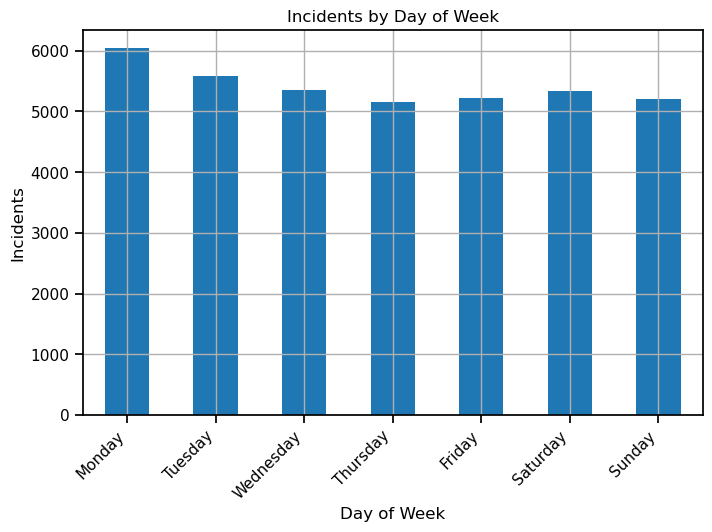

In [ ]:

if "DAY_OF_WEEK" in df.columns:
  order = ["Monday", "Tuesday", "Wednesday",
           "Thursday", "Friday", "Saturday", "Sunday"]
  counts = df["DAY_OF_WEEK"].value_counts().reindex(order)
  ax = counts.plot(kind="bar")
  ax.set_title("Incidents by Day of Week")
  ax.set_xlabel("Day of Week")
  ax.set_ylabel("Incidents")
  plt.xticks(rotation=45, ha="right")
  plt.show()
else:
  print("DAY_OF_WEEK not available.")

> **Key Takeaway:**  
> Monday shows the highest number of reported incidents citywide, with a steady but slightly lower volume on the remaining days.  
> This suggests that early-week patrols and resource allocations could be prioritized, as activity peaks right after the weekend.


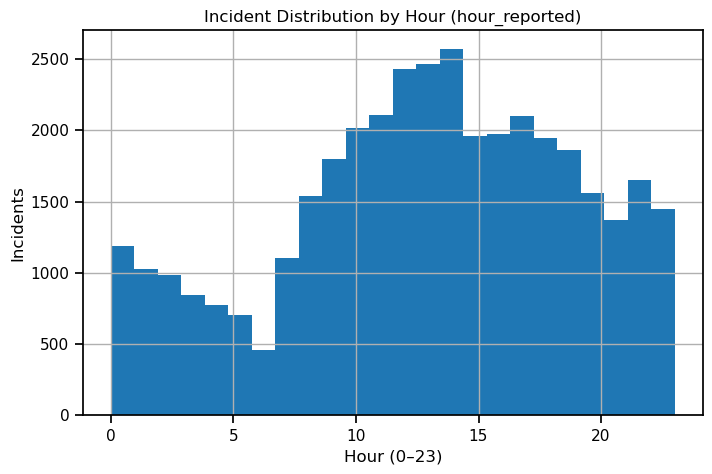

In [ ]:

hour_col = None
for candidate in ["hour_reported", "Hour_From"]:
  if candidate in df.columns:
    hour_col = candidate
    break

if hour_col:
  ax = df[hour_col].dropna().astype(int).plot(kind="hist", bins=24)
  ax.set_title(f"Incident Distribution by Hour ({hour_col})")
  ax.set_xlabel("Hour (0–23)")
  ax.set_ylabel("Incidents")
  plt.show()
else:
  print("No hour column available for histogram.")

> **Key Takeaway:**  
> Reported incidents rise sharply during daytime hours, peaking between late morning and mid-afternoon (around 11 AM–3 PM).  
> This pattern suggests increased activity and visibility during business hours, indicating that midday patrols and community outreach could be most effective.


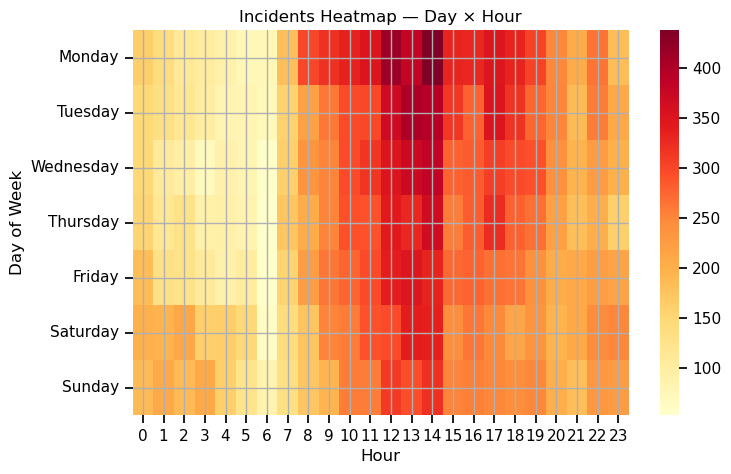

In [ ]:

if ("DAY_OF_WEEK" in df.columns) and (hour_col is not None):
  order = ["Monday", "Tuesday", "Wednesday",
           "Thursday", "Friday", "Saturday", "Sunday"]
  pivot = (df.dropna(subset=[hour_col])
             .assign(hr=df[hour_col].astype(int))
             .groupby(["DAY_OF_WEEK", "hr"])
             .size()
             .reset_index(name="n"))
  pivot["DAY_OF_WEEK"] = pd.Categorical(
      pivot["DAY_OF_WEEK"], categories=order, ordered=True)
  heat = pivot.pivot(index="DAY_OF_WEEK", columns="hr", values="n").fillna(0)

  sns.heatmap(heat, cmap="YlOrRd")
  plt.title("Incidents Heatmap — Day × Hour")
  plt.xlabel("Hour")
  plt.ylabel("Day of Week")
  plt.show()
else:
  print("Cannot build Day × Hour heatmap.")

> **Key Takeaway:**  
> The highest concentration of incidents occurs between late morning and early evening (roughly 11 AM–6 PM) across most weekdays,  
> with Monday and Tuesday showing the strongest midday peaks.  
> This consistent daytime clustering highlights prime hours for patrol deployment and neighborhood visibility initiatives.


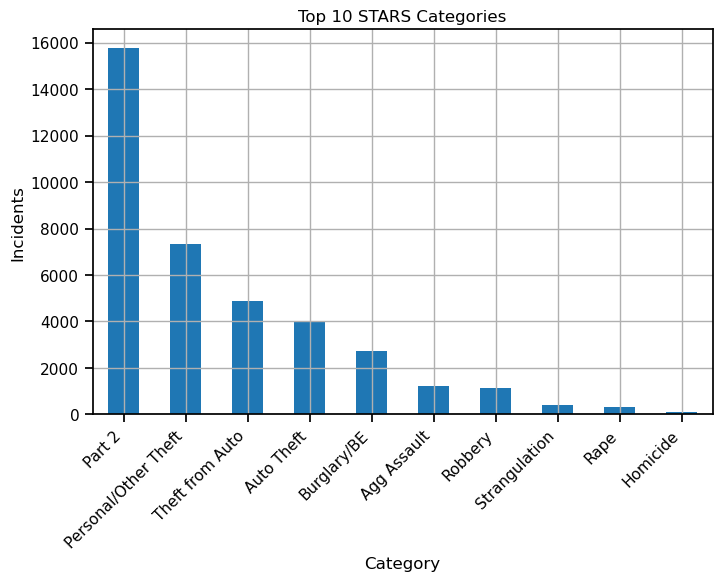

In [ ]:

if "STARS_Category" in df.columns:
  topN = 10
  counts = df["STARS_Category"].value_counts().head(topN)
  ax = counts.plot(kind="bar")
  ax.set_title(f"Top {topN} STARS Categories")
  ax.set_xlabel("Category")
  ax.set_ylabel("Incidents")
  plt.xticks(rotation=45, ha="right")
  plt.show()
else:
  print("STARS_Category not available.")

> **Key Takeaway:**  
> The majority of reported offenses fall under **“Part 2”** and **“Personal/Other Theft”** categories, with property-related crimes—such as theft from auto, auto theft, and burglary—making up the largest share of all reported incidents.  
> Violent crimes like aggravated assault, robbery, rape, and homicide represent a much smaller proportion overall, indicating that most public safety concerns in this dataset are centered around property crime rather than personal violence.

> **About “Part 2”:**  
> In police reporting terminology, **Part 2 offenses** generally refer to **non-index crimes**—less severe or secondary offenses not included in the FBI’s Uniform Crime Reporting (UCR) “Part 1” index.  
> These can include **vandalism, disorderly conduct, fraud, drug violations, minor assaults, or traffic-related offenses.**  
> The high count for “Part 2” suggests a broad grouping of miscellaneous, lower-level incidents that still impact overall safety and quality of life in the community.


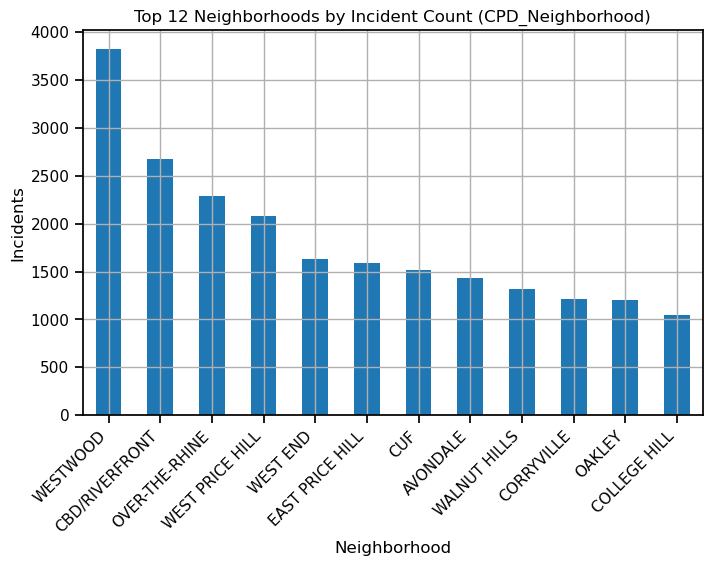

In [ ]:

neigh_col = None
for candidate in ["CPD_Neighborhood", "SNA_Neighborhood", "CC_Neighborhood"]:
  if candidate in df.columns:
    neigh_col = candidate
    break

if neigh_col:
  topN = 12
  counts = df[neigh_col].value_counts().head(topN)
  ax = counts.plot(kind="bar")
  ax.set_title(f"Top {topN} Neighborhoods by Incident Count ({neigh_col})")
  ax.set_xlabel("Neighborhood")
  ax.set_ylabel("Incidents")
  plt.xticks(rotation=45, ha="right")
  plt.show()
else:
  print("No neighborhood column found.")

> **Key Takeaway:**  
> The **Westwood** neighborhood reports the highest number of incidents citywide, followed by **CBD/Riverfront**, **Over-the-Rhine**, and **West Price Hill**.  
> These areas combine high population density, commercial activity, and major transit corridors—factors often correlated with greater reporting volume.  
> Concentrated prevention and community engagement efforts in these top neighborhoods could have the most immediate impact on overall citywide safety metrics.


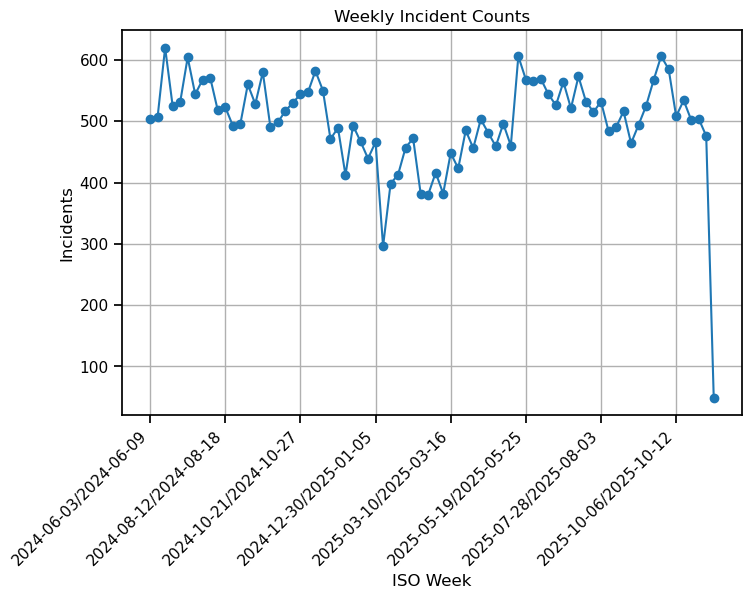

In [ ]:

if "week" in df.columns:
  ts = df.groupby("week").size().reset_index(name="n").sort_values("week")
  ax = ts.set_index("week")["n"].plot(kind="line", marker="o")
  ax.set_title("Weekly Incident Counts")
  ax.set_xlabel("ISO Week")
  ax.set_ylabel("Incidents")
  plt.xticks(rotation=45, ha="right")
  plt.show()
else:
  print("Week column unavailable.")

> **Key Takeaway:**  
> Weekly incident counts remain fairly consistent between **450–600 incidents per week**, showing normal fluctuations throughout the year.  
> A noticeable dip occurs during **early 2025**, which could reflect seasonal effects, reporting delays, or temporary decreases in activity.  
> The sharp decline at the dataset’s end likely represents **incomplete data for the most recent week** rather than an actual drop in incidents.


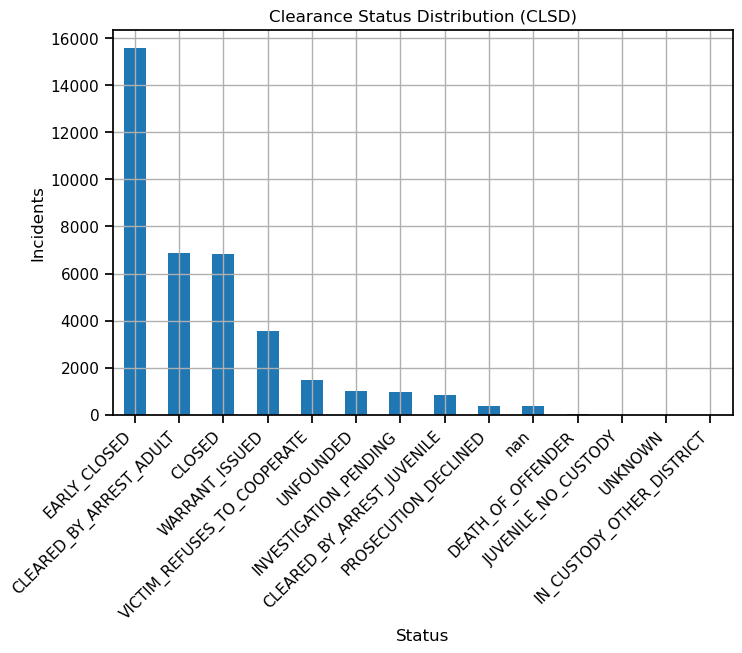

In [ ]:

if "CLSD" in df.columns:
  counts = df["CLSD"].value_counts()
  ax = counts.plot(kind="bar")
  ax.set_title("Clearance Status Distribution (CLSD)")
  ax.set_xlabel("Status")
  ax.set_ylabel("Incidents")
  plt.xticks(rotation=45, ha="right")
  plt.show()
else:
  print("CLSD not available.")

> **Key Takeaway:**  
> Most incidents are marked as **“Early Closed,” “Cleared by Arrest (Adult),”** or simply **“Closed,”** indicating that a large portion of cases reach administrative resolution relatively quickly.  
> Lower counts in categories like **“Warrant Issued”** and **“Investigation Pending”** show fewer cases require extended follow-up.  
> This distribution suggests that the majority of reported crimes are processed efficiently, though additional review of **“Victim Refuses to Cooperate”** and **“Unfounded”** cases could help identify barriers to successful case closure.


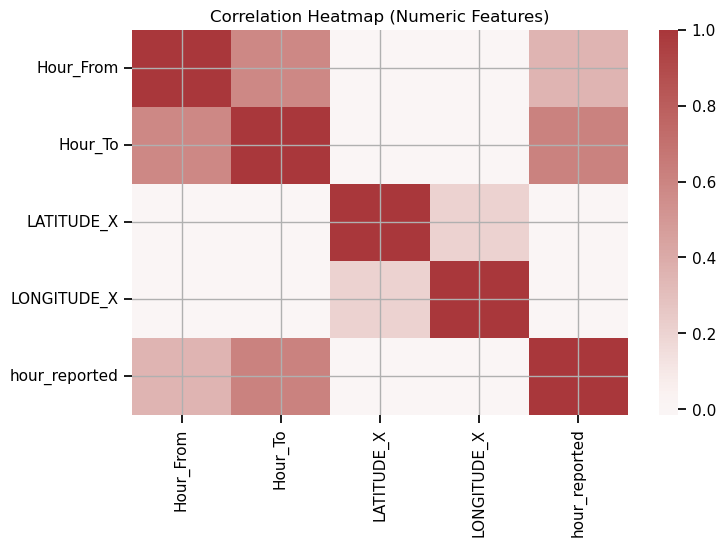

In [ ]:

num = df.select_dtypes(include="number")
if num.shape[1] >= 2:
  corr = num.corr()
  sns.heatmap(corr, cmap="vlag", center=0)
  plt.title("Correlation Heatmap (Numeric Features)")
  plt.show()
else:
  print("Not enough numeric columns for correlation heatmap.")

> **Key Takeaway:**  
> The strongest correlations appear between **Hour_From, Hour_To, and hour_reported**, confirming internal consistency in the dataset’s time features.  
> Geographic coordinates (Latitude and Longitude) show little correlation with time fields, as expected.  
> Overall, this heatmap validates that numeric variables are independent enough for analysis and that time-based features were parsed correctly.


In [ ]:

if PLOTLY_AVAILABLE and {"LATITUDE_X", "LONGITUDE_X"}.issubset(df.columns):
  sub = df.dropna(subset=["LATITUDE_X", "LONGITUDE_X"]).copy()
  sub = sub.head(5000)  # guard for rendering
  fig = px.scatter_geo(
      sub,
      lat="LATITUDE_X", lon="LONGITUDE_X",
      color="STARS_Category" if "STARS_Category" in sub.columns else None,
      hover_data=[c for c in ["INCIDENT_NO", "DateReported",
                              "CPD_Neighborhood", "STARS_Category", "CLSD"] if c in sub.columns],
      title="Incidents Map (block‑level randomized coordinates)"
  )
  fig.update_layout(height=550)
  fig.show()
else:
  print("Plotly unavailable or missing lat/lon; skipping map.")

> **Takeaway:**  
> Spatial clustering (even with block-level jitter) helps prioritize area-based responses and environmental design changes.  
> 🔍 **Note:** You may need to zoom in to the **Cincinnati metro area** on the map to clearly view neighborhood-level clustering and density patterns.


In [ ]:

if PLOTLY_AVAILABLE and {"STARS_Category", "month"}.issubset(df.columns):
  cats = df["STARS_Category"].dropna().value_counts().head(8).index.tolist()
  data_by_cat = (
      df[df["STARS_Category"].isin(cats)]
      .groupby(["STARS_Category", "month"]).size().reset_index(name="n")
      .sort_values(["STARS_Category", "month"])
  )
  # Build a single figure with dropdown to switch category
  base_cat = cats[0] if cats else None
  if base_cat:
    base = data_by_cat[data_by_cat["STARS_Category"] == base_cat]
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=base["month"], y=base["n"], mode="lines+markers", name=base_cat))
    buttons = []
    for c in cats:
      dat = data_by_cat[data_by_cat["STARS_Category"] == c]
      buttons.append(dict(
          method="update",
          label=c,
          args=[{"x": [dat["month"]], "y": [dat["n"]], "type": "scatter"},
                {"title": f"Monthly Incidents — {c}"}]
      ))
    fig.update_layout(
        title=f"Monthly Incidents — {base_cat}",
        updatemenus=[dict(type="dropdown", x=0.0, y=1.15,
                          showactive=True, buttons=buttons)],
        xaxis_title="Month", yaxis_title="Incidents", height=500
    )
    fig.show()
else:
  print("Plotly unavailable or insufficient columns for category trend.")

> **Takeaway:** Track top categories month‑over‑month for capacity planning and campaign timing.

## Conclusions  

This analysis of the **Cincinnati Police Department’s STARS Category Offenses (post–June 3, 2024)** provides a clear snapshot of current crime dynamics across time, category, and geography. Overall, reported incidents remain relatively steady week to week, with distinct peaks and concentrations that can guide data-driven safety planning.  

- **Temporal Patterns:** Most incidents occur during **daytime and early evening hours (11 AM–6 PM)**, with **Monday** showing the highest overall activity. These consistent weekday peaks highlight when targeted patrols, visibility campaigns, and neighborhood engagement may yield the greatest impact.  
- **Category Insights:** Property-related crimes—including **Part 2 offenses, thefts, and burglaries**—dominate the dataset, far outnumbering violent crimes. This suggests a continued need for preventive strategies like theft deterrence, environmental design improvements, and public education around vehicle and property security.  
- **Neighborhood Trends:** A handful of neighborhoods—**Westwood, CBD/Riverfront, Over-the-Rhine, and West Price Hill**—account for a significant share of total incidents. Concentrating cross-agency efforts in these areas could reduce citywide totals most efficiently.  
- **Operational Takeaways:** The majority of cases are resolved under **“Early Closed”** or **“Cleared by Arrest (Adult)”**, reflecting relatively efficient case handling. Monitoring categories such as **“Victim Refuses to Cooperate”** may uncover opportunities to improve community trust and victim engagement.  
- **Data Quality Check:** Numeric field correlations confirmed consistent time data and appropriate independence between spatial and temporal variables, supporting reliable downstream analysis.  

**In summary**, Cincinnati’s reported crime landscape is **stable but spatially and temporally uneven**. Daytime property crimes drive the majority of incident volume, and a small group of neighborhoods experience disproportionate activity. Using this dataset, the City and CPD can focus on **time-targeted patrol scheduling, neighborhood-specific prevention efforts, and improved community partnerships** to maximize public safety outcomes.  

**Limitations:**  
- Location data is **block-level randomized**, preventing address-level precision.  
- Dataset excludes **calls for service, arrests, and adjudication outcomes**—integrating those would offer a fuller operational picture.  
- Because of the **RMS transition on June 3 2024**, comparisons to earlier data require schema alignment and validation.  


## 📚 Appendix & References  

**Primary Data Sources:**  
- **City of Cincinnati Open Data Portal — Public Safety:**  
  [Reported Crime (STARS Category Offenses) on or after 6/3/2024](https://data.cincinnati-oh.gov/safety/Reported-Crime-STARS-Category-Offenses-on-or-after/7aqy-xrv9/about_data)  
- **City of Cincinnati Open Data Portal — Historical Records (before 6/3/2024):**  
  [Reported Crime (STARS Category Offenses) before 6/3/2024](https://data.cincinnati-oh.gov/safety/Reported-Crime-STARS-Category-Offenses-before-6-3-/8xzn-kpn7/about_data)  
- **CincyInsights Dashboard:**  
  [CincyInsights — Public Safety Overview](https://insights.cincinnati-oh.gov/stories/s/8eaa-xrvz)  
- **City of Cincinnati — Data Usage & How-To Guide:**  
  [Open Data How-To Guide](https://data.cincinnati-oh.gov/dataset/Open-Data-How-To-Guide/gdr9-g3ad)  

**Related Resources & Documentation:**  
- **Cincinnati Police Department (CPD):** [https://www.cincinnati-oh.gov/police/](https://www.cincinnati-oh.gov/police/)  
- **Office of Performance & Data Analytics (OPDA):** [https://performance.cincinnati-oh.gov/](https://performance.cincinnati-oh.gov/)  
- **FBI Uniform Crime Reporting (UCR) Program:** [https://www.fbi.gov/services/cjis/ucr](https://www.fbi.gov/services/cjis/ucr)  
- **National Incident-Based Reporting System (NIBRS):** [https://nibrs.fbi.gov](https://nibrs.fbi.gov)  
- **U.S. Department of Justice — Bureau of Justice Statistics (BJS):** [https://bjs.ojp.gov/](https://bjs.ojp.gov/)  